# Topic Modeling for Finding Table Titles Relevant to Drug-Adverse Events

- The following codes is implemented for topic modeling through LDA in attempt to find document samples(table title data) relevant to drug and adverse events.
- Topic modeling is one of statistical modeling for discovering the abstract 'topics' that occur in a collection of document.
 - An example of topic model is used to classify text in a document to a particular topic
 - it builds a topic per document model and words per topic model, modeled as Dirichlet distributions
- Following urls and research articles were referenced.
 - https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
 - http://www.engear.net/wp/topic-modeling-gensimpython/
 - https://markroxor.github.io/gensim/static/notebooks/lda_training_tips.html
 - https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore
 - https://markroxor.github.io/gensim/static/notebooks/lda_training_tips.html
 - http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb
 - http://jeriwieringa.com/2018/07/17/pyLDAviz-and-Mallet/#comment-4018495276
 - https://ldavis.cpsievert.me/reviews/reviews.html
 - https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

### Latent Dirichlet Allocation

#### Data Retrival

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

In [3]:
#retrieve table titles from csv
data = pd.read_csv('titles.csv', delimiter='\t', error_bad_lines=True, header=None)
data.columns = ['id', 'title']
data.title = data.title.str.strip()
documents = data
documents['title'].replace('', np.nan, inplace=True)
documents = documents.astype(str)
print('checking if text is missing')
print(documents.isna().any())
# documents.dropna(subset=['title'], inplace=True)
documents.shape

checking if text is missing
id       False
title    False
dtype: bool


(45352, 2)

#### Data Pre-processing
- tokenization : 
  - split the text into sentences and then sentences into words
  - lower case words
  - remove punctuation
  - remove words with fewer than 2 characters
  - remove all stopwords + added ('table', 'legend')
- Lemmatization : 
 - verbs in past and future tenses are changed into present
- Stemmazation :
 - words are reduced to their root form

In [4]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.parsing.preprocessing import strip_numeric
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

In [5]:
np.random.seed(2018)

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/grace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
stemmer = SnowballStemmer('english')
STOP_WORDS = list(gensim.parsing.preprocessing.STOPWORDS)
STOP_WORDS.extend(['table', 'legend'])

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
#     deacc=True removes punctuations
    for token in gensim.utils.simple_preprocess(text, deacc=True):
        if token not in STOP_WORDS and len(token)>1:
#             result.append(lemmatize_stemming(strip_numeric(token)))
            result.append(lemmatize_stemming(token))
    return result

In [7]:
%%time
#process the text, save the results as processed_docs
processed_docs = pd.DataFrame()
processed_docs = pd.concat([documents.id, documents.title.map(preprocess)], axis=1)
processed_docs[:5]

CPU times: user 10.8 s, sys: 52 ms, total: 10.9 s
Wall time: 10.9 s


- Trigram model : implement n-grams with Gensim Phrases

In [8]:
#TESTING MIN_COUNT
import itertools

def check_trends_with_min_count(min_count):
    bigram = gensim.models.Phrases(processed_docs.title, min_count=min_count, threshold=1)
    trigram = gensim.models.Phrases(bigram[processed_docs.title], threshold=1)

    #sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    #generated n-grams
    n_grams = []
    word_2d = processed_docs.map(lambda x: trigram_mod[bigram_mod[x]])
    for words in word_2d:
        n_grams.extend(list(filter(lambda x : x.find('_')>=0, words)))
    return set(n_grams)

# n_gram_file = open('n_gram_by_min_count.csv', 'w')
# test_min_counts = list(itertools.chain(range(1, 2), range(50, 500, 50)))
# n_gram_matrix = []
# matrix_index = 0
# for i in reversed(test_min_counts):
#     print('min_count %d' %i)
#     print('matrix_index %d' %matrix_index)
#     if matrix_index > 0:
#         n_gram_matrix.append(list(set(check_trends_with_min_count(i)) - set(n_gram_matrix[matrix_index-1])))
#     else:
#         n_gram_matrix.append(list(set(check_trends_with_min_count(i))))
#     n_gram_file.write(str(i)+'\t'+str(n_gram_matrix[matrix_index])+'\n')
#     matrix_index += 1

# n_gram_file.close()

In [9]:
%%time
#min_count = ignore all words and bigrams with total collected count lower than this value
#threshold = represent a score threshold for forming the phrases(higher means fewer phrases)
bigram = gensim.models.Phrases(processed_docs.title, min_count=1, threshold=0.3)
trigram = gensim.models.Phrases(bigram[processed_docs.title], threshold=0.3)

#sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 6.42 s, sys: 12 ms, total: 6.43 s
Wall time: 6.43 s


In [10]:
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

In [11]:
def make_bigram(text):
    processed_text = [[word for word in simple_preprocess(str(doc)) if word not in STOP_WORDS] for doc in text]
    return [bigram_mod[doc] for doc in processed_text]

def make_trigram(text):
    processed_text = [[word for word in simple_preprocess(str(doc)) if word not in STOP_WORDS] for doc in text]
    return trigram_mod[[bigram_mod[doc] for doc in processed_text]]

def explain_make_trigram(text):
    conversion = {}
    for doc in text:
        pro_doc = simple_preprocess(str(doc))
        if doc!= pro_doc:
            print(doc)
            print(pro_doc)
            conversion[doc]=pro_doc
    return conversion

def n_gram_lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    text_out = []
    for sent in text:
        doc = nlp(' '.join(sent))
        text_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return text_out

def explain_n_gram_lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    conversions = {}
    for sent in text:
        doc = nlp(' '.join(sent))
        for token in doc:
            if len(token.lemma_) <4 and str(token)!=str(token.lemma_):
                conversions[token] = token.lemma_
#                 print('%s : %s' (token, token.lemma_))
    return conversions

In [12]:
%%time
processed_bigram = n_gram_lemmatization(make_bigram(processed_docs.title))
processed_trigram = n_gram_lemmatization(make_trigram(processed_docs.title))
print(str(len(processed_bigram)))
print(str(len(processed_trigram)))
processed_docs['bigram'] = processed_bigram
processed_docs['trigram'] = processed_trigram
processed_docs.head(10)

45352
45352
CPU times: user 12min 8s, sys: 22min 33s, total: 34min 42s
Wall time: 4min 25s


In [13]:
#checking bigram
# count = 0
# for ind, bigram in enumerate(processed_bigram):
#     for bi in bigram:
#         if bi.find('_')>=0:
#             print(bi)
#     if any(bi.find('_')>=0 for bi in bigram) and count<10:
#         print(bigram)
#         count +=1

# for ind, trigram in enumerate(processed_trigram):
#     for bi in trigram:
#         if bi.find('_')>=0:
#             print(bi)

### bag of words on the data set
- create a dictionary from 'processed_docs' containing the number of times a word appears in the training set

In [14]:
#############
dictionary_made_by = processed_trigram
dictionary_made_by_str = 'trigram'

dictionary = gensim.corpora.Dictionary(dictionary_made_by)
print('size of the dictionary %d' %len(dictionary))
max_dic_size = len(dictionary)
test_dic_sizes = [max_dic_size, int(max_dic_size*2/3), int(max_dic_size/2), 10000]

# count = 0
# for k, v in dictionary.iteritems():
#     if v.find('_')>=0:
#         print(k,v)
#     count += 1
#     if count > 200:
#         break
#     if v.find('tion')>=0:
#         print(k,v)

size of the dictionary 41339


In [15]:
# filter out tokens that appear in less than 0.05 documents 
# or more than 0.5 documents
# after above, keep only the first 40000 most frequent tokens.

#############
dict_size = test_dic_sizes[0]
dictionary.filter_extremes(no_below=0.08, no_above=0.8, keep_n=dict_size)

In [16]:
# vectorize
# Bag-of-words representation of the documents
bow_corpus = [dictionary.doc2bow(doc) for doc in dictionary_made_by]

bow_doc_100 = bow_corpus[100]
for i in range(len(bow_doc_100)):
    print("Word {} (\"{}\") appears {} times.".format(bow_doc_100[i][0],
                                                     dictionary[bow_doc_100[i][0]],
                                                     bow_doc_100[i][1]))

processed_docs['bow_corpus'] = bow_corpus
processed_docs.head(10)

Word 285 ("calcif_score") appears 1 times.
Word 286 ("clinic_correl") appears 1 times.
Word 287 ("coronari_arteri") appears 1 times.


,id,title,bigram,trigram,bow_corpus
0,4105,"[baselin, characterist]",[baselin_characterist],[baselin_characterist],"[(0, 1)]"
1,4106,"[analysi, efficaci]",[analysi_efficaci],[analysi_efficaci],"[(1, 1)]"
2,4107,"[comparison, postop, carbohydr, antigen, level...","[comparison_postop, carbohydr_antigen, level, ...","[comparison_postop, carbohydr_antigen, level, ...","[(2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1..."
3,4108,"[pattern, diseas, relaps]","[pattern_disea, relap]","[pattern_disea, relap]","[(10, 1), (11, 1)]"
4,4109,"[grade, advers, event, gemcitabin, gemcitabin,...","[grade_adver, event_gemcitabin, gemcitabin, pl...","[grade_adver, event_gemcitabin, gemcitabin, pl...","[(12, 1), (13, 1), (14, 1), (15, 1)]"
5,4111,"[baselin, characterist]",[baselin_characterist],[baselin_characterist],"[(0, 1)]"
6,4112,"[treatment, zoledron, acid]","[treatment, zoledron_acid]","[treatment, zoledron_acid]","[(16, 1), (17, 1)]"
7,4113,"[treatment, docetaxel]","[treatment, docetaxel]","[treatment, docetaxel]","[(16, 1), (18, 1)]"
8,4114,"[treatment, relaps, discret, treat, clinician]","[treatment, relap, discret, treat, clinician]","[treatment, relap, discret, treat, clinician]","[(11, 1), (16, 1), (19, 1), (20, 1), (21, 1)]"
9,4115,"[worst, advers, event, grade, report, entir, t...","[worst_adver, event_grade, report, entir, time...","[worst_adver, event_grade, report, entir, time...","[(22, 1), (23, 1), (24, 1), (25, 1), (26, 1)]"


#### TF-IDF
- tf-idf model on bow_corpus

- tf = count(word, document) / len(document)
- idf = log( len(collection) / count(document_containing_term, collection)
- tf-idf = tf * idf

In [17]:
from gensim import corpora, models
from pprint import pprint

tfidf_mod = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf_mod[bow_corpus]

processed_docs['tfidf_corpus'] = tfidf_corpus
tfidf_doc_100 = tfidf_corpus[100]
for i in range(len(tfidf_doc_100)):
    print("Word {} (\"{}\") appears {} times.".format(tfidf_doc_100[i][0],
                                                     dictionary[tfidf_doc_100[i][0]],
                                                     tfidf_doc_100[i][1]))

Word 285 ("calcif_score") appears 0.6923875844084906 times.
Word 286 ("clinic_correl") appears 0.6165414603864825 times.
Word 287 ("coronari_arteri") appears 0.3748013614989662 times.


In [18]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents bow corpus: %d' % len(bow_corpus))
print('Number of documents tfidf: %d' % len(tfidf_corpus))
print('Number of documents : %d' % len(dictionary_made_by))

Number of unique tokens: 41339
Number of documents bow corpus: 45352
Number of documents tfidf: 45352
Number of documents : 45352


#### Optimal number of topics
- build many LDA models with different values of number of topics and pick the one that gives the highest coherence value based on corpus
- 토픽 모델링 결과로 나온 주제들에 대해 각각의 주제에서 상위 N개의 단어를 뽑습니다. 모델링이 잘 되었을수록 한 주제 안에는 의미론적으로 유사한 단어가 많이 모여있게 마련입니다. 따라서 상위 단어 간의 유사도를 계산하면 실제로 해당 주제가 의미론적으로 일치하는 단어들끼리 모여있는지 알 수 있습니다.

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

def compute_coherence_values(model_type, dictionary, corpus, texts, limit, start=2, step=3):
    """
    compute c_v coherence for various number of topics
    
    parameters:
    dictionary : gensim dictionary
    corpus : gensim corpus
    texts : list of input texts
    limit : max number of topics
    
    returns:
    model_list : list of LDA topic models
    coherence_values : coherence value
    """
    
    coherenece_values = []
    u_mass_coherenece_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        if model_type == 'mallet':
            model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, \
                                                     num_topics=num_topics, \
                                                     id2word=dictionary, workers=8, \
                                                     iterations=60)
        elif model_type == 'online':
            model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, \
                                                    num_topics=num_topics, update_every=0, \
                                                    passes=20)
        else:
            model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, \
                                               id2word=dictionary, passes=2, \
                                               workers=8, iterations=60)
        
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        u_mass_coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        
        coherenece_values.append(coherence_model.get_coherence())
        u_mass_coherenece_values.append(u_mass_coherence_model.get_coherence())

    return model_list, coherenece_values, u_mass_coherenece_values

def find_optimal_topic_num(model_type, model_list, coherence_values, umass_co_val):   
    #graph
    print('======== '+model_type + ' ========')
    fig = plt.figure(figsize=(10,5))

    x = range(start, limit, step)
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(x, coherence_values)
    ax1.set_xlabel("Number of Topics")
    ax1.set_ylabel("Coherence score")
    #     plt.legend(("coherence_values"), loc="best")

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(x, umass_co_val)
    ax2.set_xlabel("Number of Topics")
    ax2.set_ylabel("u mass Coherence score")
    #     plt.legend(("u mass coherence_values"), loc="best")

    fig.savefig(directory+'/'+model_type+'_coherence.png')

    # Print the coherence scores
    # one that maximizes the topic coherence
    print('Coherence c_v ================')
    max_coherence_topic_num = 8 #default
    prev_co = 0
    first_max_cohe_found = False
    for m, cv in zip(x, coherence_values):
        cur_coherence = round(cv, 4)
        print("Num Topics =", m, " has Coherence cv Value of", cur_coherence)
#         if (cur_coherence > 0.32) and m > 5:
        if m > 5:
            if (prev_co <= cur_coherence) and not first_max_cohe_found:
                max_coherence_topic_num = m
            else:
                first_max_cohe_found = True
        prev_co = cur_coherence
    print('Best number of topic is : %d' %max_coherence_topic_num)

    print('Coherence umass ================')
    #where score plateaus안정
    for m, um in zip(x, umass_co_val):
        print("Num Topics =", m, " has Coherence umass Value of", round(um, 4))
    
    return max_coherence_topic_num

In [20]:
model_config='dic_'+dictionary_made_by_str+'_size_'+str(len(dictionary))

import os
directory ='./stat_files/'+model_config
if not os.path.exists(directory):
    os.makedirs(directory)

======== online ========
Coherence c_v ================
Num Topics = 2  has Coherence cv Value of 0.4488
Num Topics = 3  has Coherence cv Value of 0.459
Num Topics = 4  has Coherence cv Value of 0.512
Num Topics = 5  has Coherence cv Value of 0.4845
Num Topics = 6  has Coherence cv Value of 0.5088
Num Topics = 7  has Coherence cv Value of 0.5029
Num Topics = 8  has Coherence cv Value of 0.4775
Num Topics = 9  has Coherence cv Value of 0.4707
Num Topics = 10  has Coherence cv Value of 0.4852
Num Topics = 11  has Coherence cv Value of 0.5094
Num Topics = 12  has Coherence cv Value of 0.5162
Num Topics = 13  has Coherence cv Value of 0.5132
Num Topics = 14  has Coherence cv Value of 0.5084
Num Topics = 15  has Coherence cv Value of 0.5025
Num Topics = 16  has Coherence cv Value of 0.4846
Num Topics = 17  has Coherence cv Value of 0.4962
Num Topics = 18  has Coherence cv Value of 0.5203
Num Topics = 19  has Coherence cv Value of 0.5016
Num Topics = 20  has Coherence cv Value of 0.5044
Num 

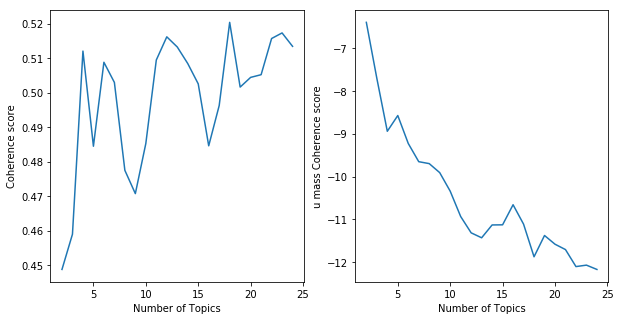

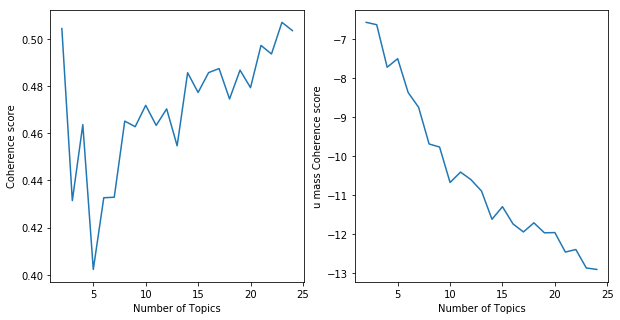

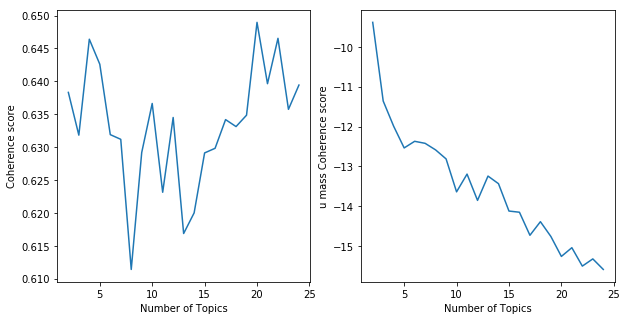

In [21]:
# %%time
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = './mallet-2.0.8/bin/mallet'
from gensim.models import CoherenceModel
limit = 25; start=2; step=1;

model_list_on, coherence_values_on, umass_co_val_on = compute_coherence_values(model_type='online', dictionary=dictionary, \
                                                                      corpus=bow_corpus, \
                                                                      texts=processed_trigram, \
                                                                      start=start, \
                                                                      limit=limit, \
                                                                      step=step)
max_coherence_topic_num_on= find_optimal_topic_num('online', model_list_on, coherence_values_on, umass_co_val_on)

model_list, coherence_values, umass_co_val = compute_coherence_values(model_type='mallet', dictionary=dictionary, \
                                                                      corpus=bow_corpus, \
                                                                      texts=processed_trigram, \
                                                                      start=start, \
                                                                      limit=limit, \
                                                                      step=step)
max_coherence_topic_num = find_optimal_topic_num('mallet', model_list, coherence_values, umass_co_val)

model_list_tfidf, coherence_values_tfidf, umass_co_val_tfidf = compute_coherence_values(model_type='tfidf', dictionary=dictionary, \
                                                                                              corpus=tfidf_corpus, \
                                                                                              texts=processed_trigram, \
                                                                                              start=start, \
                                                                                              limit=limit, \
                                                                                              step=step)
max_coherence_topic_num_tfidf = find_optimal_topic_num('tfidf', model_list_tfidf, coherence_values_tfidf, umass_co_val_tfidf)

### LDA using bag of words

- train LDA using gensim.models.LdaMulticore

In [22]:
# lda_model_bow = gensim.models.LdaMulticore(bow_corpus, num_topics=8, id2word=dictionary, passes=2, workers=2)
# for idx, topic in lda_model_bow.print_topics(-1):
#     print('Topic: {} \nWords: {}'.format(idx, topic))

#is mallet better?
from pathlib import Path
import math

dir_to_check = Path(directory+'/data/')
if not dir_to_check.is_dir():
    os.makedirs(directory+'/data/')
    
# def check_duplicate_keywords(topics):
#     all_keywords = {}
#     for topic in topics:
#         for t in topic.:
#             if all_keywords[t] is None:
#                 all_keywords[t] = 1
#             else:
#                 all_keywords[t] = all_keywords[t] + 1
        

def get_optimal_model(model_type, optimal_topic_num):
#     optimal_topic_num = max_coherence_topic_num
    if model_type=='mallet':
        model = gensim.models.wrappers.LdaMallet(mallet_path=mallet_path, \
                                                      corpus=bow_corpus, \
                                                      num_topics=optimal_topic_num, \
                                                      id2word=dictionary,\
                                                      iterations=100,\
                                                      prefix=directory+'/data/')
    elif model_type=='online':
        model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus, id2word=dictionary, \
                                                    num_topics=optimal_topic_num, update_every=0, \
                                                    passes=20)
    else:
        model = gensim.models.LdaMulticore(tfidf_corpus,\
                                             num_topics=max_coherence_topic_num_tfidf, \
                                             id2word=dictionary, \
                                             passes=2, \
                                             workers=8,\
                                            iterations=100)
        
    #show topics
    topics = model.show_topics(formatted=False)
    pprint(topics)
    # lda_mallet.save('./data/mallet_topics_num_'+str(optimal_topic_num)+'_'+model_config+'.state.gz')
#     model.load_word_topics()
  
    fig = plt.figure(figsize=(15,20))
    fig.suptitle(model_type+'_topics_num_'+str(optimal_topic_num)+'_'+model_config)

    for i in range(optimal_topic_num):
        df=pd.DataFrame(model.show_topic(i), columns=['term','prob']).set_index('term')

        axi = fig.add_subplot(math.ceil(optimal_topic_num/2),2,i+1)
        axi.set_title('topic '+str(i+1))
        sns.barplot(x='prob', y=df.index, data=df, palette='Reds_d')
        axi.set_xlabel('probability')

    # plt.show()
    fig.savefig(directory+'/'+model_type+'_topics_num_'+str(optimal_topic_num)+'.png')
    return model

[(0,
  [('characterist_patient', 0.016821345707656612),
   ('popul', 0.009358081979891724),
   ('baselin_characterist', 0.008313998453209591),
   ('studi', 0.007772621809744779),
   ('model', 0.007501933488012374),
   ('hazard_ratio', 0.0066125290023201855),
   ('procedur', 0.0066125290023201855),
   ('clinic_characterist', 0.006109822119102861),
   ('mortal', 0.005491105955143078),
   ('rate', 0.005259087393658159)]),
 (1,
  [('advers_event', 0.00946226632817909),
   ('number', 0.0089237633664128),
   ('comparison', 0.008769905377336719),
   ('treatment', 0.007692899453804139),
   ('baselin_characterist', 0.00661589353027156),
   ('month', 0.006500500038464497),
   ('univari_analysi', 0.006269713054850373),
   ('diagnosi', 0.006192784060312331),
   ('subject', 0.005808139087622125),
   ('valu', 0.0057312100930840834)]),
 (2,
  [('risk_factor', 0.014655799181112004),
   ('baselin_characterist', 0.0141966096506333),
   ('characterist', 0.013967014885393947),
   ('group', 0.0117475988214

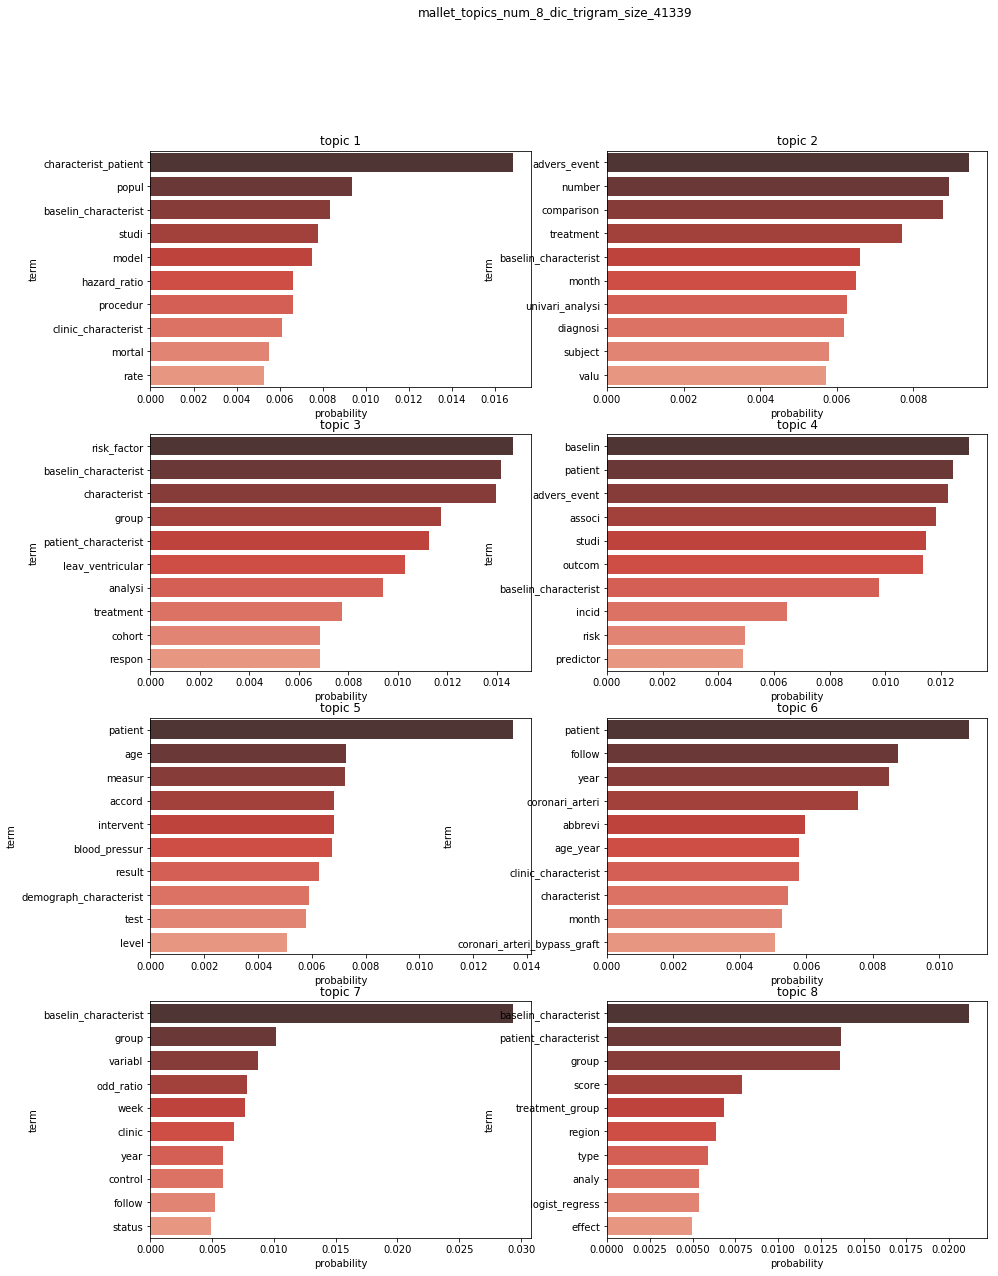

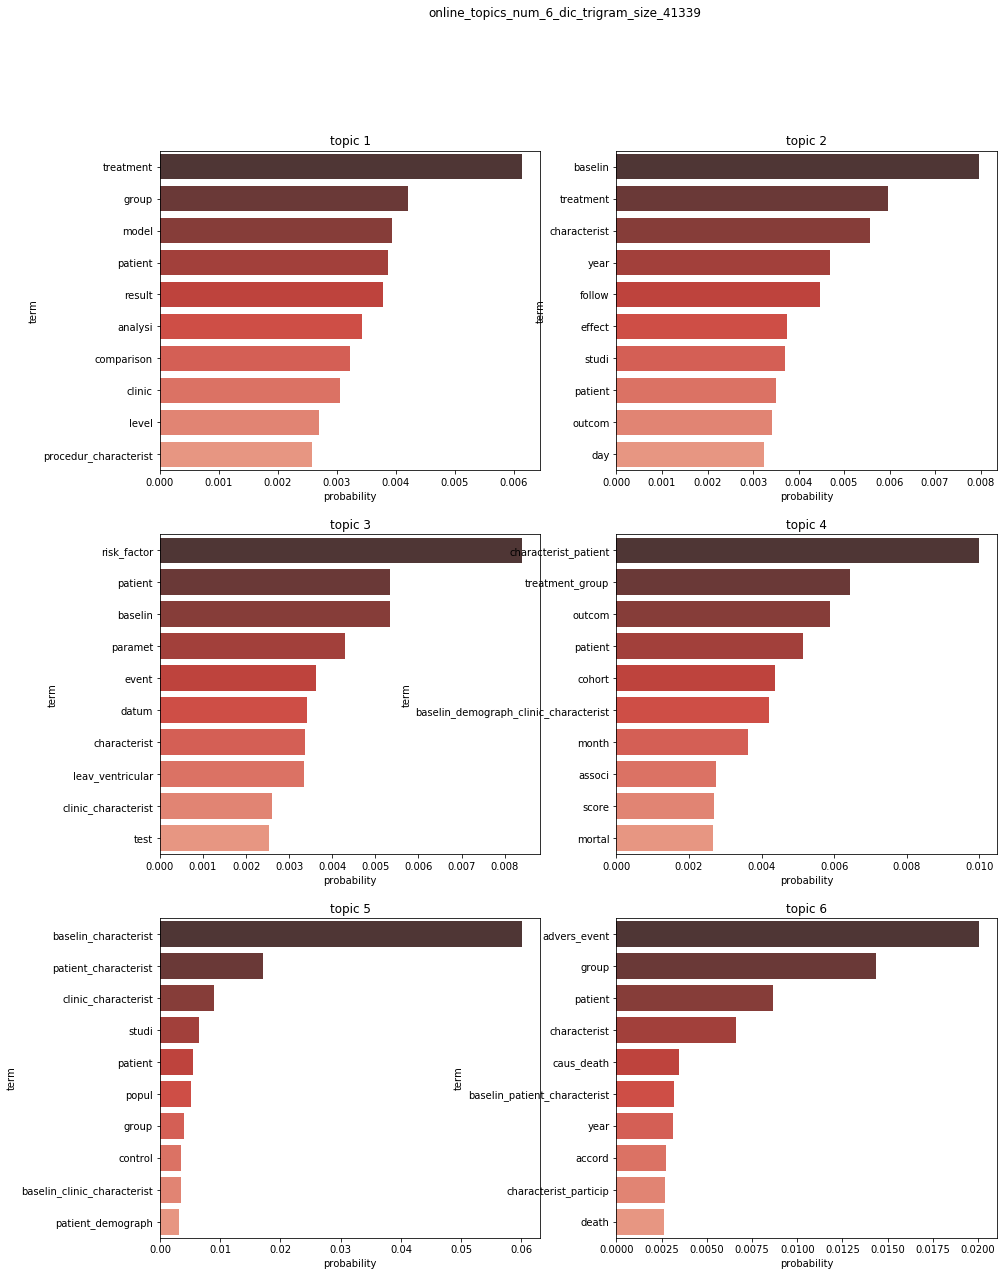

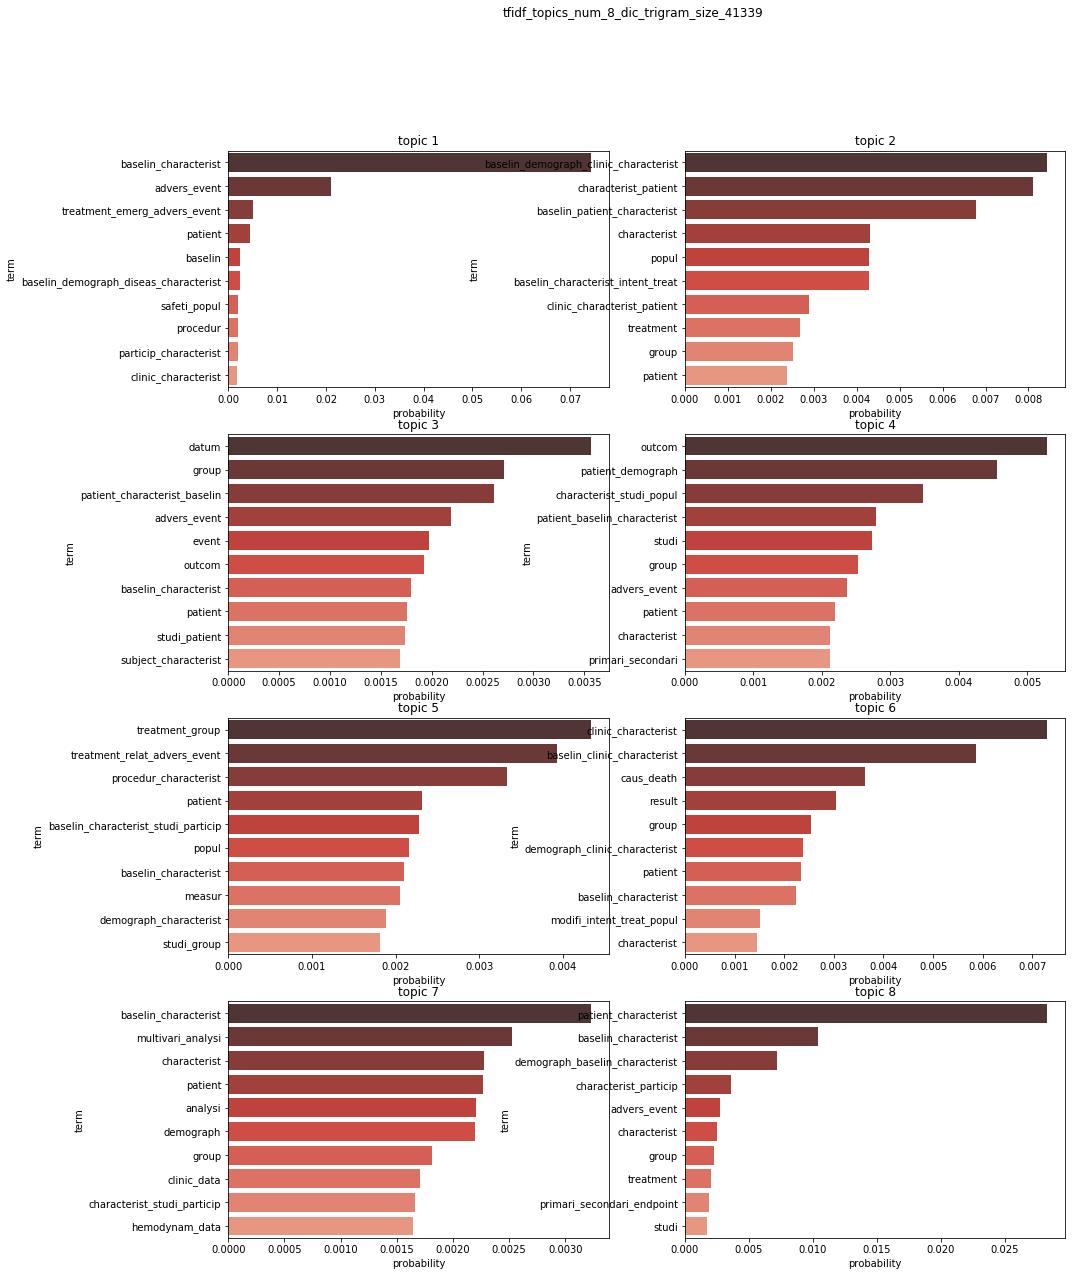

In [23]:
mallet_model = get_optimal_model('mallet', max_coherence_topic_num)
on_model = get_optimal_model('online', max_coherence_topic_num_on)
tfidf_model = get_optimal_model('tfidf', max_coherence_topic_num_tfidf)

In [24]:
# #Check topic distribution of a sample data
# for ind, score in sorted(lda_mallet[bow_corpus[45]], key=lambda x: -1*x[1]):
#     print('\nScore: {}\t \nTopic: {}'.format(score, lda_mallet.print_topic(ind, 10)))

In [25]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [26]:
import gzip
import os

dataDir = directory+'/data/'

def extract_params(statefile):
    """extract alpha and beta values from MALLET statefile by path to statfile
    
    Args:
        statefile (str) : Path to statefile produced by MALLET
    Returns:
        tuple: alpha (list), beta
    """
    
#     with codecs.open(statefile, "r",encoding='utf-8') as state:
    with gzip.open(statefile, 'r') as state:
        params = [x.decode('utf-8').strip() for x in state.readlines()[1:3]]
#         params = [x.strip() for x in state.readlines()[1:3]]
    return (list(params[0].split(':')[1].split(" ")), float(params[1].split(':')[1]))

def state_to_df(statefile):
    """transform state file into pandas dataframe
    the MALLET statefile is tab-separated, and the first two rows contain the alpha and beta parameters
    
    Args:
        statefile (str): Path to statefile produced by MALLET
    Returns:
        dataframe: topic assignment for each token in each documnet of the model
    """
    return pd.read_csv(statefile,\
                      compression='gzip',\
                      sep=' ',\
                      skiprows=[1,2])

In [27]:
params = extract_params(os.path.join(dataDir, 'state.mallet.gz'))
alpha = [float(x) for x in params[0][1:]]
beta = params[1]
print("{}, {}".format(alpha, beta))

df = state_to_df(os.path.join(dataDir, 'state.mallet.gz'))
df['type'] = df.type.astype(str)
df[:5]
#doc id, word position index, word index, topic assignmnet

[6.25, 6.25, 6.25, 6.25, 6.25, 6.25, 6.25, 6.25], 0.01


,#doc,source,pos,typeindex,type,topic
0,0,NaN,0,0,baselin_characterist,2
1,1,NaN,0,1,analysi_efficaci,3
2,2,NaN,0,2,carbohydr_antigen,1
3,2,NaN,1,3,comparison_postop,3
4,2,NaN,2,4,conoko,2


In [28]:
#to get the length of the document, group by the document id and count the tokens
docs = df.groupby('#doc')['type'].count().reset_index(name='doc_length')
docs[:10]

#get vocab and term frequencies
vocab = df['type'].value_counts().reset_index()
vocab.columns = ['type', 'term_freq']
vocab = vocab.sort_values(by='type', ascending=True)
vocab[:5]

,type,term_freq
39130,aa,1
22977,aa_androgen,2
29005,aa_aortic,1
35522,aa_caucasian,1
22546,aa_user,2


In [29]:
#matrix file
#need to normalize data so that each row sums to 1
import sklearn.preprocessing

def pivot_and_smooth(df, smooth_values, rows_variable, cols_variable, values_variable):
    """
    modify dataframe into matrix
    Args:
        df (dataframe) : 
        smooth_values (float) : value to add to the matrix to account for the priors
        rows_variable (str) : title of rows
        cols_variable (str) : title of columns
        values_variable (str) : values
    Returns:
        dataframe : that has been normalized on the rows.
    """
    matrix = df.pivot(index=rows_variable, columns=cols_variable, values=values_variable).fillna(value=0)
    matrix = matrix.values + smooth_values
    
    normed = sklearn.preprocessing.normalize(matrix, norm='l1', axis=1)
    
    return pd.DataFrame(normed)

In [30]:
#get the number of topic assingments for words in documents
#phi - topic-term matrix and counted the number of times each word was assigned to each topic 
#and sorted by alphabetically to match the order of the vocabulary frame

#beta as the smoothign value
phi_df = df.groupby(['topic', 'type'])['type'].count().reset_index(name='token_count')
phi_df = phi_df.sort_values(by='type', ascending=True)
phi_df[:5]

phi = pivot_and_smooth(phi_df, beta, 'topic', 'type', 'token_count')
phi[:5]

#theta document-topic matrix and use alpha as the smoothign value
theta_df = df.groupby(['#doc', 'topic'])['topic'].count().reset_index(name='topic_count')
theta_df[:5]

theta = pivot_and_smooth(theta_df, alpha, '#doc', 'topic', 'topic_count')
theta[:5]

,0,1,2,3,4,5,6,7
0,0.122549,0.122549,0.142157,0.122549,0.122549,0.122549,0.122549,0.122549
1,0.122549,0.122549,0.122549,0.142157,0.122549,0.122549,0.122549,0.122549
2,0.125000,0.125000,0.125000,0.193966,0.107759,0.107759,0.107759,0.107759
3,0.139423,0.120192,0.139423,0.120192,0.120192,0.120192,0.120192,0.120192
4,0.115741,0.134259,0.134259,0.115741,0.115741,0.115741,0.134259,0.134259


In [31]:
lda_mallet_data = {
    'topic_term_dists':phi,
    'doc_topic_dists':theta,
    'doc_lengths':list(docs['doc_length']),
    'vocab':list(vocab['type']),
    'term_frequency':list(vocab['term_freq'])
}
mallet_vis_data = pyLDAvis.prepare(**lda_mallet_data)
pyLDAvis.display(mallet_vis_data)
pyLDAvis.save_html(mallet_vis_data, directory+'/mallet_topics_num_'+str(max_coherence_topic_num)+'.html')

In [32]:
#each bubble = topic, the larger the bubble, the more prevalent is that topic
#good topic = fairly big, non-overlapping bubbles scattered throughout the chart
#model with too many topics = typically have many overlaps, small sized bubbles in one region of the chart
data_tfidf = pyLDAvis.gensim.prepare(tfidf_model, tfidf_corpus, dictionary)
data_tfidf

#bar = salient keywords that form the selected topic
pyLDAvis.display(data_tfidf)
pyLDAvis.save_html(data_tfidf, directory+'/tfidf_topics_num_'+str(max_coherence_topic_num_tfidf)+'.html')

data_on = pyLDAvis.gensim.prepare(on_model, bow_corpus, dictionary)
data_on

pyLDAvis.display(data_on)
pyLDAvis.save_html(data_on, directory+'/online_topics_num_'+str(max_coherence_topic_num_on)+'.html')

#### Perplexity and Coherence score
- model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is

In [33]:
#compute perplexity : a measure of how good the model is
# lower the better
# print('\nPerplexit: ', lda_mallet.log_perplexity(bow_corpus))
# print('\nPerplexit: ', lda_model_tfidf.log_perplexity(bow_corpus))

In [34]:
from gensim.models import CoherenceModel

#compute coherence score
coherence_model_lda = CoherenceModel(model=mallet_model, texts=processed_trigram, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

#compute coherence score
coherence_model_lda_tfidf = CoherenceModel(model=tfidf_model, texts=processed_trigram, dictionary=dictionary, coherence='c_v')
coherence_lda_tfidf = coherence_model_lda_tfidf.get_coherence()
print('\nTF-IDF Coherence Score: ', coherence_lda_tfidf)

#compute coherence score
coherence_model_lda_on = CoherenceModel(model=on_model, texts=processed_trigram, dictionary=dictionary, coherence='c_v')
coherence_lda_on = coherence_model_lda_on.get_coherence()
print('\nONLINE Coherence Score: ', coherence_lda_on)


Coherence Score:  0.45714271006811735

TF-IDF Coherence Score:  0.6419906260596177

ONLINE Coherence Score:  0.5033022350887184


### Find dominant topic
- find the most contributed topic

In [35]:
processed_docs = processed_docs.merge(documents, on='id')
# test = processed_docs[['id', 'title_x', 'bow_corpus', 'title_y']]
# test.to_csv('test.csv')

In [36]:
processed_docs.head(5)

,id,title_x,bigram,trigram,bow_corpus,tfidf_corpus,title_y
0,4105,"[baselin, characterist]",[baselin_characterist],[baselin_characterist],"[(0, 1)]","[(0, 1.0)]",Baseline characteristics
1,4106,"[analysi, efficaci]",[analysi_efficaci],[analysi_efficaci],"[(1, 1)]","[(1, 1.0)]",Analysis of efficacy
2,4107,"[comparison, postop, carbohydr, antigen, level...","[comparison_postop, carbohydr_antigen, level, ...","[comparison_postop, carbohydr_antigen, level, ...","[(2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1...","[(2, 0.39752766247848675), (3, 0.3975276624784...",Comparisons of postoperative carbohydrate anti...
3,4108,"[pattern, diseas, relaps]","[pattern_disea, relap]","[pattern_disea, relap]","[(10, 1), (11, 1)]","[(10, 0.7869055698976604), (11, 0.617073434903...",Pattern of disease relapse
4,4109,"[grade, advers, event, gemcitabin, gemcitabin,...","[grade_adver, event_gemcitabin, gemcitabin, pl...","[grade_adver, event_gemcitabin, gemcitabin, pl...","[(12, 1), (13, 1), (14, 1), (15, 1)]","[(12, 0.5579883460967343), (13, 0.521916671983...",Grade 1–5 adverse events with gemcitabine alon...


In [37]:
processed_docs.iloc[151]

id                                                           4261
title_x         [paramet, initi, pattern, af, valu, present, m...
bigram          [paramet_initi, pattern, valu_present, mean_st...
trigram         [paramet_initi, pattern, valu_present, mean_st...
bow_corpus      [(550, 2), (551, 1), (552, 1), (553, 1), (554,...
tfidf_corpus    [(550, 0.6255186243282894), (551, 0.4005040363...
title_y         Electrophysiologic Parameters of Two Initiatio...
Name: 151, dtype: object

In [38]:
import random

def format_topics_sentences(model, \
                            model_type='mallet', \
                            corpus=processed_docs, \
                            texts=dictionary_made_by):
    sent_topic_df = pd.DataFrame()
    if model_type=='tfidf':
        target_corpus = corpus.tfidf_corpus
    else:
        target_corpus = corpus.bow_corpus
    
    for i, row in enumerate(model[target_corpus]):
        origin_info = processed_docs.iloc[i]
        text_vec = texts[i]
        #get main topic in each document
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0: #dominant topic
                wp = model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
#                 print(pd.Series([origin_info.id,\
#                                 int(topic_num), \
#                                 round(prop_topic, 4), \
#                                 topic_keywords, \
#                                origin_info.title_y, \
#                                text_vec]))
                sent_topic_df = sent_topic_df.append(pd.Series([origin_info.id,\
                                                                int(topic_num), \
                                                                round(prop_topic, 4), \
                                                                topic_keywords, \
                                                               origin_info.title_y, \
                                                               text_vec]), ignore_index=True)
            else:
                break
    sent_topic_df.columns = ['id', 'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Origin_Text', 'Text_Vec']
    
    return (sent_topic_df)

In [39]:
df_topic_sents_keywords_mallet = format_topics_sentences(model=mallet_model, \
                                                  corpus=processed_docs, \
                                                  texts=dictionary_made_by, \
                                                 model_type='mallet')
df_topic_sents_keywords_mallet.head(max_coherence_topic_num)

,id,Dominant_Topic,Perc_Contribution,Topic_Keywords,Origin_Text,Text_Vec
0,4105,7.0,0.1334,"baselin_characterist, patient_characterist, gr...",Baseline characteristics,[baselin_characterist]
1,4106,3.0,0.1334,"baselin, patient, advers_event, associ, studi,...",Analysis of efficacy,[analysi_efficaci]
2,4107,3.0,0.1786,"baselin, patient, advers_event, associ, studi,...",Comparisons of postoperative carbohydrate anti...,"[comparison_postop, carbohydr_antigen, level, ..."
3,4108,0.0,0.1394,"characterist_patient, popul, baselin_character...",Pattern of disease relapse,"[pattern_disea, relap]"
4,4109,6.0,0.1404,"baselin_characterist, group, variabl, odd_rati...",Grade 1–5 adverse events with gemcitabine alon...,"[grade_adver, event_gemcitabin, gemcitabin, pl..."
5,4111,7.0,0.1291,"baselin_characterist, patient_characterist, gr...",Baseline characteristics,[baselin_characterist]
6,4112,7.0,0.1394,"baselin_characterist, patient_characterist, gr...",Treatment with zoledronic acid,"[treatment, zoledron_acid]"
7,4113,1.0,0.1416,"advers_event, number, comparison, treatment, b...",Treatment with docetaxel,"[treatment, docetaxel]"


In [40]:
df_topic_sents_keywords_tfidf = format_topics_sentences(model=tfidf_model, \
                                                  corpus=processed_docs, \
                                                  texts=dictionary_made_by, \
                                                 model_type='tfidf')
df_topic_sents_keywords_tfidf.head(max_coherence_topic_num_tfidf)

,id,Dominant_Topic,Perc_Contribution,Topic_Keywords,Origin_Text,Text_Vec
0,4105,0.0,0.5624,"baselin_characterist, advers_event, treatment_...",Baseline characteristics,[baselin_characterist]
1,4106,2.0,0.5625,"datum, group, patient_characterist_baselin, ad...",Analysis of efficacy,[analysi_efficaci]
2,4107,1.0,0.7648,"baselin_demograph_clinic_characterist, charact...",Comparisons of postoperative carbohydrate anti...,"[comparison_postop, carbohydr_antigen, level, ..."
3,4108,6.0,0.6355,"baselin_characterist, multivari_analysi, chara...",Pattern of disease relapse,"[pattern_disea, relap]"
4,4109,2.0,0.7063,"datum, group, patient_characterist_baselin, ad...",Grade 1–5 adverse events with gemcitabine alon...,"[grade_adver, event_gemcitabin, gemcitabin, pl..."
5,4111,0.0,0.5624,"baselin_characterist, advers_event, treatment_...",Baseline characteristics,[baselin_characterist]
6,4112,1.0,0.6228,"baselin_demograph_clinic_characterist, charact...",Treatment with zoledronic acid,"[treatment, zoledron_acid]"
7,4113,1.0,0.6244,"baselin_demograph_clinic_characterist, charact...",Treatment with docetaxel,"[treatment, docetaxel]"


In [41]:
df_topic_sents_keywords_on = format_topics_sentences(model=on_model, \
                                                  corpus=processed_docs, \
                                                  texts=dictionary_made_by, \
                                                 model_type='online')
df_topic_sents_keywords_on.head(max_coherence_topic_num_on)

,id,Dominant_Topic,Perc_Contribution,Topic_Keywords,Origin_Text,Text_Vec
0,4105,4.0,0.5833,"baselin_characterist, patient_characterist, cl...",Baseline characteristics,[baselin_characterist]
1,4106,4.0,0.5816,"baselin_characterist, patient_characterist, cl...",Analysis of efficacy,[analysi_efficaci]
2,4107,1.0,0.9071,"baselin, treatment, characterist, year, follow...",Comparisons of postoperative carbohydrate anti...,"[comparison_postop, carbohydr_antigen, level, ..."
3,4108,2.0,0.7218,"risk_factor, patient, baselin, paramet, event,...",Pattern of disease relapse,"[pattern_disea, relap]"
4,4109,2.0,0.8320,"risk_factor, patient, baselin, paramet, event,...",Grade 1–5 adverse events with gemcitabine alon...,"[grade_adver, event_gemcitabin, gemcitabin, pl..."
5,4111,4.0,0.5833,"baselin_characterist, patient_characterist, cl...",Baseline characteristics,[baselin_characterist]


In [42]:
print(df_topic_sents_keywords_mallet.isna().any())
print('=================')
print(df_topic_sents_keywords_tfidf.isna().any())
print('=================')
print(df_topic_sents_keywords_on.isna().any())

id                   False
Dominant_Topic       False
Perc_Contribution    False
Topic_Keywords       False
Origin_Text          False
Text_Vec             False
dtype: bool
id                   False
Dominant_Topic       False
Perc_Contribution    False
Topic_Keywords       False
Origin_Text          False
Text_Vec             False
dtype: bool
id                   False
Dominant_Topic       False
Perc_Contribution    False
Topic_Keywords       False
Origin_Text          False
Text_Vec             False
dtype: bool


#### 각 토픽별로 가장 대표적인 문서 찾기

In [43]:
def get_rep_sents(keywords, model_type):
    sent_topics_sorted_df_mallet = pd.DataFrame()
    
    sent_topics_groupby = keywords.groupby('Dominant_Topic')

    keywords_top = pd.DataFrame()
    for i, grp in sent_topics_groupby:
        keywords_top = pd.concat([keywords_top, \
                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(20)], \
                            axis=0)
        keywords = pd.concat([keywords, \
                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(20)], \
                            axis=0)

    keywords_top.reset_index(drop=True, inplace=True)
    keywords_top.columns = ['id', 'Topic_Num', 'Topic_Perc_Contribu', 'Topic_Keywords', 'Origin_Text', 'Text']
    keywords_top.to_csv(directory+'/'+model_type+'_top_sen.tsv', sep='\t')
    
    keywords.reset_index(drop=True, inplace=True)
    keywords.columns = ['id', 'Topic_Num', 'Topic_Perc_Contribu', 'Topic_Keywords', 'Origin_Text', 'Text']
    
    return keywords
    
df_topic_sents_mallet = get_rep_sents(df_topic_sents_keywords_mallet, 'mallet')
df_topic_sents_tfidf = get_rep_sents(df_topic_sents_keywords_tfidf, 'tfidf')
df_topic_sents_on = get_rep_sents(df_topic_sents_keywords_on, 'online')

In [44]:
df_topic_sents_keywords_mallet.head(5)

,id,Dominant_Topic,Perc_Contribution,Topic_Keywords,Origin_Text,Text_Vec
0,4105,7.0,0.1334,"baselin_characterist, patient_characterist, gr...",Baseline characteristics,[baselin_characterist]
1,4106,3.0,0.1334,"baselin, patient, advers_event, associ, studi,...",Analysis of efficacy,[analysi_efficaci]
2,4107,3.0,0.1786,"baselin, patient, advers_event, associ, studi,...",Comparisons of postoperative carbohydrate anti...,"[comparison_postop, carbohydr_antigen, level, ..."
3,4108,0.0,0.1394,"characterist_patient, popul, baselin_character...",Pattern of disease relapse,"[pattern_disea, relap]"
4,4109,6.0,0.1404,"baselin_characterist, group, variabl, odd_rati...",Grade 1–5 adverse events with gemcitabine alon...,"[grade_adver, event_gemcitabin, gemcitabin, pl..."


In [45]:
df_topic_sents_mallet.head(5)

,id,Topic_Num,Topic_Perc_Contribu,Topic_Keywords,Origin_Text,Text
0,4105,7.0,0.1334,"baselin_characterist, patient_characterist, gr...",Baseline characteristics,[baselin_characterist]
1,4106,3.0,0.1334,"baselin, patient, advers_event, associ, studi,...",Analysis of efficacy,[analysi_efficaci]
2,4107,3.0,0.1786,"baselin, patient, advers_event, associ, studi,...",Comparisons of postoperative carbohydrate anti...,"[comparison_postop, carbohydr_antigen, level, ..."
3,4108,0.0,0.1394,"characterist_patient, popul, baselin_character...",Pattern of disease relapse,"[pattern_disea, relap]"
4,4109,6.0,0.1404,"baselin_characterist, group, variabl, odd_rati...",Grade 1–5 adverse events with gemcitabine alon...,"[grade_adver, event_gemcitabin, gemcitabin, pl..."


In [46]:
df_topic_sents_tfidf.head(5)

,id,Topic_Num,Topic_Perc_Contribu,Topic_Keywords,Origin_Text,Text
0,4105,0.0,0.5624,"baselin_characterist, advers_event, treatment_...",Baseline characteristics,[baselin_characterist]
1,4106,2.0,0.5625,"datum, group, patient_characterist_baselin, ad...",Analysis of efficacy,[analysi_efficaci]
2,4107,1.0,0.7648,"baselin_demograph_clinic_characterist, charact...",Comparisons of postoperative carbohydrate anti...,"[comparison_postop, carbohydr_antigen, level, ..."
3,4108,6.0,0.6355,"baselin_characterist, multivari_analysi, chara...",Pattern of disease relapse,"[pattern_disea, relap]"
4,4109,2.0,0.7063,"datum, group, patient_characterist_baselin, ad...",Grade 1–5 adverse events with gemcitabine alon...,"[grade_adver, event_gemcitabin, gemcitabin, pl..."


In [47]:
df_topic_sents_tfidf.__len__()

45512

#### 문서 전체적인 토픽 분포

In [48]:
pd.set_option('display.max_colwidth', -1)

topic_counts = df_topic_sents_mallet['Topic_Num'].value_counts()
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

topic_num_keywords = df_topic_sents_mallet[['Topic_Num', 'Topic_Keywords']]

df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)
df_dominant_topics.reset_index(level=0, inplace=True)
df_dominant_topics.columns = ['Topic_Num', 'Num_Documents', 'Perc_Documents']
df_dominant_topics = df_dominant_topics.merge(topic_num_keywords.drop_duplicates(), on='Topic_Num')
df_dominant_topics = df_dominant_topics.sort_values('Topic_Num')

df_dominant_topics.reset_index(drop = True, inplace = True)
df_dominant_topics.to_html(directory+'/mallet_distribution.html', index=False)
df_dominant_topics.head(max_coherence_topic_num)

,Topic_Num,Num_Documents,Perc_Documents,Topic_Keywords
0,0.0,7243,0.1591,"characterist_patient, popul, baselin_characterist, studi, model, hazard_ratio, procedur, clinic_characterist, mortal, rate"
1,1.0,5912,0.1299,"advers_event, number, comparison, treatment, baselin_characterist, month, univari_analysi, diagnosi, subject, valu"
2,2.0,6022,0.1323,"risk_factor, baselin_characterist, characterist, group, patient_characterist, leav_ventricular, analysi, treatment, cohort, respon"
3,3.0,5648,0.1241,"baselin, patient, advers_event, associ, studi, outcom, baselin_characterist, incid, risk, predictor"
4,4.0,5013,0.1101,"patient, age, measur, accord, intervent, blood_pressur, result, demograph_characterist, test, level"
5,5.0,5060,0.1112,"patient, follow, year, coronari_arteri, abbrevi, age_year, clinic_characterist, characterist, month, coronari_arteri_bypass_graft"
6,6.0,5364,0.1179,"baselin_characterist, group, variabl, odd_ratio, week, clinic, year, control, follow, status"
7,7.0,5250,0.1154,"baselin_characterist, patient_characterist, group, score, treatment_group, region, type, analy, logist_regress, effect"


In [49]:
topic_counts = df_topic_sents_tfidf['Topic_Num'].value_counts()
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

topic_num_keywords = df_topic_sents_tfidf[['Topic_Num', 'Topic_Keywords']]

df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)
df_dominant_topics.reset_index(level=0, inplace=True)
df_dominant_topics.columns = ['Topic_Num', 'Num_Documents', 'Perc_Documents']
df_dominant_topics = df_dominant_topics.merge(topic_num_keywords.drop_duplicates(), on='Topic_Num')
df_dominant_topics = df_dominant_topics.sort_values('Topic_Num')

df_dominant_topics.reset_index(drop = True, inplace = True)
df_dominant_topics.to_html(directory+'/tfidf_distribution.html', index=False)
df_dominant_topics.head(max_coherence_topic_num)

,Topic_Num,Num_Documents,Perc_Documents,Topic_Keywords
0,0.0,7856,0.1726,"baselin_characterist, advers_event, treatment_emerg_advers_event, patient, baselin, baselin_demograph_diseas_characterist, safeti_popul, procedur, particip_characterist, clinic_characterist"
1,1.0,5724,0.1258,"baselin_demograph_clinic_characterist, characterist_patient, baselin_patient_characterist, characterist, popul, baselin_characterist_intent_treat, clinic_characterist_patient, treatment, group, patient"
2,2.0,5182,0.1139,"datum, group, patient_characterist_baselin, advers_event, event, outcom, baselin_characterist, patient, studi_patient, subject_characterist"
3,3.0,5298,0.1164,"outcom, patient_demograph, characterist_studi_popul, patient_baselin_characterist, studi, group, advers_event, patient, characterist, primari_secondari"
4,4.0,5123,0.1126,"treatment_group, treatment_relat_advers_event, procedur_characterist, patient, baselin_characterist_studi_particip, popul, baselin_characterist, measur, demograph_characterist, studi_group"
5,5.0,5487,0.1206,"clinic_characterist, baselin_clinic_characterist, caus_death, result, group, demograph_clinic_characterist, patient, baselin_characterist, modifi_intent_treat_popul, characterist"
6,6.0,5382,0.1183,"baselin_characterist, multivari_analysi, characterist, patient, analysi, demograph, group, clinic_data, characterist_studi_particip, hemodynam_data"
7,7.0,5460,0.1200,"patient_characterist, baselin_characterist, demograph_baselin_characterist, characterist_particip, advers_event, characterist, group, treatment, primari_secondari_endpoint, studi"


In [50]:
topic_counts = df_topic_sents_on['Topic_Num'].value_counts()
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

topic_num_keywords = df_topic_sents_on[['Topic_Num', 'Topic_Keywords']]

df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)
df_dominant_topics.reset_index(level=0, inplace=True)
df_dominant_topics.columns = ['Topic_Num', 'Num_Documents', 'Perc_Documents']
df_dominant_topics = df_dominant_topics.merge(topic_num_keywords.drop_duplicates(), on='Topic_Num')
df_dominant_topics = df_dominant_topics.sort_values('Topic_Num')

df_dominant_topics.reset_index(drop = True, inplace = True)
df_dominant_topics.to_html(directory+'/on_distribution.html', index=False)
df_dominant_topics.head(max_coherence_topic_num)

,Topic_Num,Num_Documents,Perc_Documents,Topic_Keywords
0,0.0,7970,0.1753,"treatment, group, model, patient, result, analysi, comparison, clinic, level, procedur_characterist"
1,1.0,7068,0.1554,"baselin, treatment, characterist, year, follow, effect, studi, patient, outcom, day"
2,2.0,6619,0.1456,"risk_factor, patient, baselin, paramet, event, datum, characterist, leav_ventricular, clinic_characterist, test"
3,3.0,7567,0.1664,"characterist_patient, treatment_group, outcom, patient, cohort, baselin_demograph_clinic_characterist, month, associ, score, mortal"
4,4.0,8979,0.1975,"baselin_characterist, patient_characterist, clinic_characterist, studi, patient, popul, group, control, baselin_clinic_characterist, patient_demograph"
5,5.0,7269,0.1599,"advers_event, group, patient, characterist, caus_death, baselin_patient_characterist, year, accord, characterist_particip, death"


- https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

- https://ai.googleblog.com/2016/12/open-sourcing-embedding-projector-tool.html
- http://projector.tensorflow.org/
- http://nbviewer.jupyter.org/github/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb#loading